In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision
try:
    from torchinfo import summary
except:
    !pip install -q torchinfo
    from torchinfo import summary

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
train_set = dset.CIFAR10(root='./data', train=True, transform=trans, download=True)
test_set = dset.CIFAR10(root='./data', train=False, transform=trans)
batch_size = 32

100%|██████████| 170498071/170498071 [00:03<00:00, 53409233.43it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [4]:
train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,shuffle=False)

In [5]:
weights = torchvision.models.ResNet50_Weights.DEFAULT
model = torchvision.models.resnet50(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 148MB/s] 


In [6]:
summary(model=model,
        input_size=(64, 3, 32, 32),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 32, 32]      [64, 1000]           --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 64, 16, 16]     9,408                True
├─BatchNorm2d (bn1)                      [64, 64, 16, 16]     [64, 64, 16, 16]     128                  True
├─ReLU (relu)                            [64, 64, 16, 16]     [64, 64, 16, 16]     --                   --
├─MaxPool2d (maxpool)                    [64, 64, 16, 16]     [64, 64, 8, 8]       --                   --
├─Sequential (layer1)                    [64, 64, 8, 8]       [64, 256, 8, 8]      --                   True
│    └─Bottleneck (0)                    [64, 64, 8, 8]       [64, 256, 8, 8]      --                   True
│    │    └─Conv2d (conv1)               [64, 64, 8, 8]       [64, 64, 8, 8]       4,096                True
│    │    └─BatchN

In [7]:
# for param in model.parameters():
#     param.requires_grad = False

In [8]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
output_shape = 10
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=2048,
                    out_features=output_shape,
                    bias=True)).to(device)

In [9]:
summary(model=model,
        input_size=(64, 3, 32, 32),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 32, 32]      [64, 10]             --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 64, 16, 16]     9,408                True
├─BatchNorm2d (bn1)                      [64, 64, 16, 16]     [64, 64, 16, 16]     128                  True
├─ReLU (relu)                            [64, 64, 16, 16]     [64, 64, 16, 16]     --                   --
├─MaxPool2d (maxpool)                    [64, 64, 16, 16]     [64, 64, 8, 8]       --                   --
├─Sequential (layer1)                    [64, 64, 8, 8]       [64, 256, 8, 8]      --                   True
│    └─Bottleneck (0)                    [64, 64, 8, 8]       [64, 256, 8, 8]      --                   True
│    │    └─Conv2d (conv1)               [64, 64, 8, 8]       [64, 64, 8, 8]       4,096                True
│    │    └─BatchN

In [10]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [11]:
def train(model, data_loader, loss_fn, optimizer, accuracy_fn, train_losses, train_accuracy, device=device):
    model.to(device)
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    train_losses.append(train_loss)
    train_accuracy.append(train_acc)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

In [12]:
def test(data_loader, model, loss_fn, accuracy_fn, test_losses, test_accuracy, device=device):
    model.to(device)
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        test_losses.append(test_loss)
        test_accuracy.append(test_acc)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [13]:
model = model
# print(model)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

epochs = 10
train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []
device
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train(data_loader=train_loader,
               model=model,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device,
               train_losses=train_losses,
               train_accuracy=train_accuracy
    )
    test(data_loader=test_loader,
              model=model,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device,
              test_losses=test_losses,
              test_accuracy=test_accuracy
    )

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.02909 | Train accuracy: 66.68%


 10%|█         | 1/10 [01:05<09:47, 65.32s/it]

Test loss: 0.73374 | Test accuracy: 75.85%

Epoch: 1
---------
Train loss: 0.71236 | Train accuracy: 77.20%


 20%|██        | 2/10 [02:10<08:39, 64.98s/it]

Test loss: 0.67119 | Test accuracy: 77.64%

Epoch: 2
---------
Train loss: 0.59380 | Train accuracy: 81.24%


 30%|███       | 3/10 [03:15<07:34, 64.97s/it]

Test loss: 0.61266 | Test accuracy: 80.72%

Epoch: 3
---------
Train loss: 0.51454 | Train accuracy: 83.56%


 40%|████      | 4/10 [04:19<06:29, 64.97s/it]

Test loss: 0.52399 | Test accuracy: 82.92%

Epoch: 4
---------
Train loss: 0.44297 | Train accuracy: 85.75%


 50%|█████     | 5/10 [05:24<05:24, 64.86s/it]

Test loss: 0.56424 | Test accuracy: 81.09%

Epoch: 5
---------
Train loss: 0.38947 | Train accuracy: 87.70%


 60%|██████    | 6/10 [06:29<04:19, 64.83s/it]

Test loss: 0.52841 | Test accuracy: 82.39%

Epoch: 6
---------
Train loss: 0.32389 | Train accuracy: 89.56%


 70%|███████   | 7/10 [07:34<03:14, 64.79s/it]

Test loss: 0.54319 | Test accuracy: 82.93%

Epoch: 7
---------
Train loss: 0.29352 | Train accuracy: 90.73%


 80%|████████  | 8/10 [08:38<02:09, 64.79s/it]

Test loss: 0.57619 | Test accuracy: 82.49%

Epoch: 8
---------
Train loss: 0.26520 | Train accuracy: 91.75%


 90%|█████████ | 9/10 [09:43<01:04, 64.84s/it]

Test loss: 0.64210 | Test accuracy: 80.73%

Epoch: 9
---------
Train loss: 0.23483 | Train accuracy: 92.53%


100%|██████████| 10/10 [10:48<00:00, 64.84s/it]

Test loss: 0.57993 | Test accuracy: 83.57%



Text(0, 0.5, 'percent')

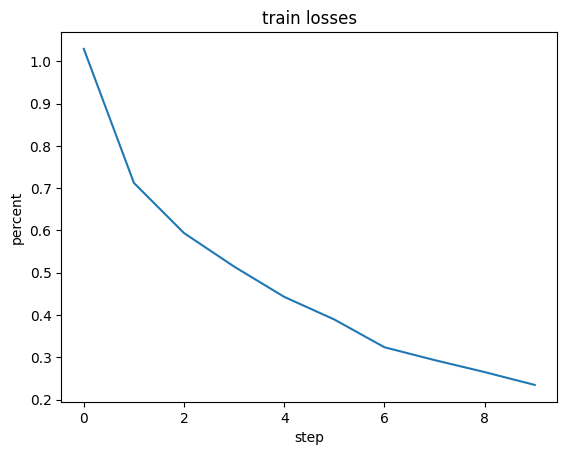

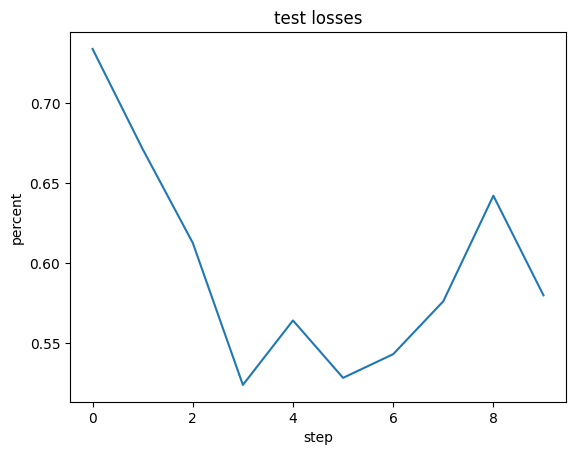

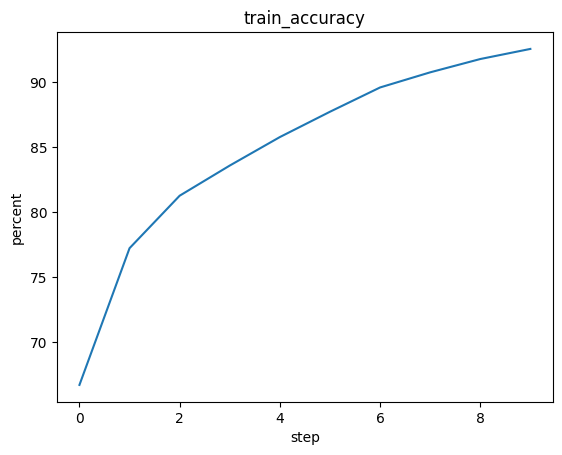

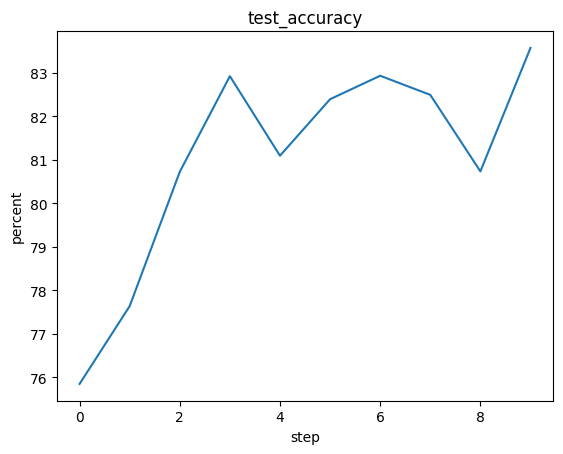

In [14]:
plt.figure()
plt.plot(train_losses)
plt.title('train losses')
plt.xlabel('step')
plt.ylabel('percent')

plt.figure()
plt.plot(test_losses)
plt.title('test losses')
plt.xlabel('step')
plt.ylabel('percent')

plt.figure()
plt.plot(train_accuracy)
plt.title('train_accuracy')
plt.xlabel('step')
plt.ylabel('percent')

plt.figure()
plt.plot(test_accuracy)
plt.title('test_accuracy')
plt.xlabel('step')
plt.ylabel('percent')

#Make Predictions

In [15]:
model.to('cpu')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
import random

idx = random.randint(0, len(test_set)-1)
feature, label = test_set[idx]
logits = model(feature.view(1,3,32,32))
print("Truth:", label)
print("Predit:", torch.argmax(logits).item())

Truth: 0
Predit: 0
